In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
from matplotlib.patches import Ellipse
import sys

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12
# plt.rcParams['text.usetex'] = True

sys.path.insert(0, '/home/aew492/CFE_gradients')
from grad_tools import load_suave_amps, check_grad_amps, grad_input, format_xi_axes
from generate_mock_list import MockSet

In [3]:
data_dir = '/scratch/aew492/CFE_gradients_output'

## functions

In [4]:
"""given volume, number density, and representative power spectrum value,
    return the expected precision of the CF estimation: equation from Weinberg OSU"""
def std_grad(V, n, P):
    std = P * (V**(-.5) * (1 + (n*P)**(-1))) * (V**(-1/3))  # last factor is from position dependence across box
    return std

In [5]:
# find corresponding k, and P_G(k), for some input separation r
def get_PkG(r, PkG_fn='/scratch/ksf293/mocks/lognormal/inputs/cat_L750_n2e-4_z057_patchy_As2x_pkG.dat'):
    kG, PkG = np.loadtxt(PkG_fn).T
    
    k = min(kG, key=lambda x:abs(x-1/r))  # closest k value to 1/r
    P = PkG[np.where(kG==k)][0]
    return k, P

In [6]:
def plot_2d_dist(grads_rec, grad_exp, figsize=(6,6), xlim=(None,None), ylim=(None,None), leg_loc=2):
    
    # medians and standard deviation
    median_rec = np.median(grads_rec, axis=0)
    std_rec = np.std(grads_rec, axis=0)
    
    fig, ax = plt.subplots(figsize=figsize)

    # plot individual realizations
    ax.plot(grads_rec[:,0], grads_rec[:,1], marker='.', color='k', alpha=0.8, markersize=2, ls='None')
    # input gradient arrow
    ax.arrow(0,0,grad_exp[0], grad_exp[1], color='blue', alpha=0.8, length_includes_head=True,
             width=0.00001, head_width=0.00015,label='input',zorder=100)

    # ellipse: spread of recovered amplitudes, centered at the median recovered gradient
    for k in range(1,4):
        ellipse1 = Ellipse(xy=(median_rec[0], median_rec[1]), width=k*2*std_rec[0], height=k*2*std_rec[1],
                           color='k', fill=True, alpha=0.2/k)
        ax.add_patch(ellipse1)
    
    # median recovered
    ax.scatter(median_rec[0], median_rec[1], color='white', alpha=0.8, lw=2, marker='x', s=80,
               zorder=100, label='median recovered')
    
    ax.axvline(0, color='k', lw=0.5, alpha=0.3)
    ax.axhline(0, color='k', lw=0.5, alpha=0.3)
    ax.set_aspect('equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'$a_x / a_0$')
    ax.set_ylabel(r'$a_y / a_0$')
    ax.set_title('Recovered gradient amplitudes')
    ax.legend(loc=leg_loc)
    fig.tight_layout()

In [7]:
def unit(vec):
    """Returns unit vector."""
    return vec / np.linalg.norm(vec)

In [8]:
def t_intersect(omega, n, a, O):
    """Returns the intersection "time" t between a plane and a line.
            omega = slope of the line
            n = normal vector to the plane
            a = point on the plane
            O = origin
    """
    # ensure unit vectors
    n = unit(n)
    omegahat = unit(omega)
    aprime = np.array(a) - np.array(O)
    # projections
    A = np.dot(n, aprime)
    B = np.dot(n, omegahat)
    # (catch if the denominator is zero)
    if B==0:
        print("this line and plane are parallel")
        t = np.inf
    else:
        t = np.dot(n, aprime) / np.dot(n, omegahat)
    return t

In [9]:
def compute_v(omega, L, O=[0,0,0]):
    """Returns distance along the "gradient line" (i.e. along omega through box center) to the box boundary."""
    omegahat = unit(omega)  # ensure unit vector
    amag = L/2  # distance to each box face from origin
    # test intersection with each plane
    comps = {0 : 'yz',
             1 : 'xz',
             2 : 'xy'}
    ts = []
    for i in comps:
        # construct unit vector
        n = np.zeros(3)
        n[i] = 1
        a = amag * n # point on this box face
        t = t_intersect(omegahat, n, a, O)  # intersection between gradient line and this box face
        ts.append(np.abs(t))  # abs because we want the min. absolute value to avoid t < 0 cases outside the box
        print(f"t = {t:.1f} for the {comps[i]}-plane")
    v = min(ts)  # the way we parameterize means that t is just the physical distance to the box edge
    comps_intersect = np.where(ts==v)[0][0]  # will be just one component unless omega is parallel to some face
    print(f"line will intersect first with the {comps[comps_intersect]} plane")
    return v

### plot slices of mock catalogs

In [10]:
grad_dim = 2
L = 750
n = '2e-4'
rlzs = 1
b = 0.5

In [11]:
# zero gradient injected
m0 = 0
mockset0 = MockSet(L, n, rlzs=rlzs)
mockset0.add_gradient(grad_dim, m0, b)
mock0_dict = mockset0.load_rlz(0)
mock0_data = mock0_dict['data']
mock0_w_hat = mock0_dict['w_hat']

In [12]:
# weak ('more realistic') gradient mock
m1 = 0.1
mockset1 = MockSet(L, n, rlzs=rlzs)
mockset1.add_gradient(grad_dim, m1, b)
mock1_dict = mockset1.load_rlz(0)
mock1_data = mock1_dict['data']
mock1_w_hat = mock1_dict['w_hat']

In [13]:
# strong gradient mock, where we can visually see the change in clustering
m2 = 1
mockset2 = MockSet(L, n, rlzs=rlzs)
mockset2.add_gradient(grad_dim, m2, b)
mock2_dict = mockset2.load_rlz(0)
mock2_data = mock2_dict['data']
mock2_w_hat = mock2_dict['w_hat']

In [14]:
# super strong gradient mock
m3 = 10
mockset3 = MockSet(L, n, rlzs=rlzs)
mockset3.add_gradient(grad_dim, m3, b)
mock3_dict = mockset3.load_rlz(0)
mock3_data = mock3_dict['data']
mock3_w_hat = mock3_dict['w_hat']

In [15]:
mock_data = [mock0_data, mock1_data, mock2_data, mock3_data]
gradients = [m0*mock0_w_hat, m1*mock1_w_hat, m2*mock2_w_hat, m3*mock3_w_hat]

In [16]:
gradients

[array([0., 0., 0.]),
 array([0.08660254, 0.05      , 0.        ]),
 array([0.8660254, 0.5      , 0.       ]),
 array([8.66025403, 5.00000002, 0.        ])]

In [17]:
# xy-slice for plotting
z_max = -200
data_slices = []
for data_set in mock_data:
    data_slices.append(data_set[np.where(data_set[:,2] < z_max)])

In [18]:
# plotting w_hat
def arrow(gradient):
    cent = [0,0]
    base = cent-gradient[:2]/2
    head = cent+gradient[:2]/2
    return base, head

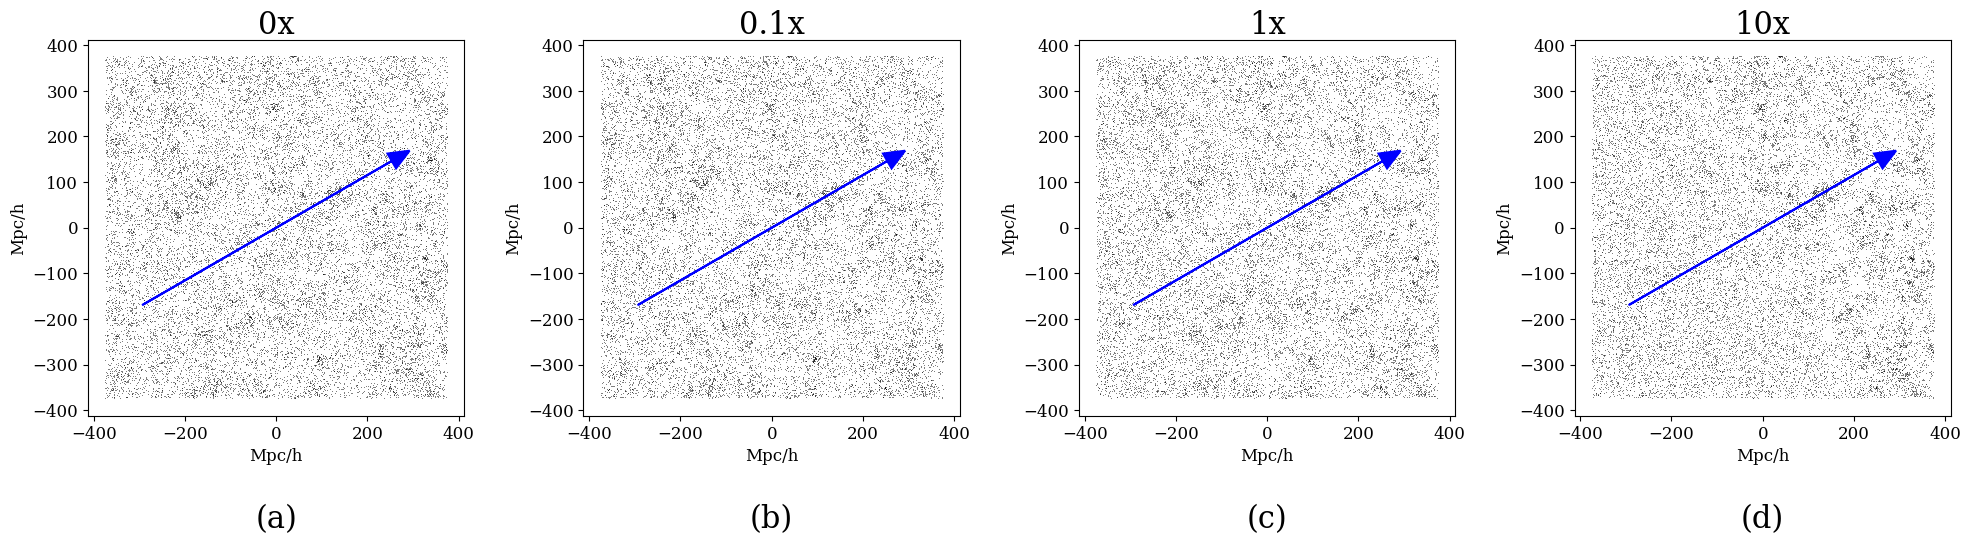

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))

# plot galaxies
i = 0
color='blue'
lw=1.5

# arrow scale
a = 0.9*L

titles = ['(a)', '(b)', '(c)', '(d)']
texts = ['0x', '0.1x', '1x', '10x']

for col in range(4):
    ax = axs[col]
    data = data_slices[i]
    ax.plot(data[:,0], data[:,1], 'k,', alpha=0.5)
    ax.set_title(titles[col], y=-.32, fontsize=22)   # letter labels
    ax.text(x=0, y=425, s=texts[col], fontsize=22, ha='center')
    # ax.set_title(r'$\omega_{input}$'+' = [ {:.2f},  {:.2f},  {:.2f} ]'.format(gradients[i][0], gradients[i][1], gradients[i][2]))

    # plot w_hat arrow
    base, head = arrow(gradients[2])   # use third mock for scaling
    b = np.linalg.norm(head-base)
    ax.arrow(a*base[0], a*base[1], 2*a*head[0], 2*a*head[1], color=color, lw=lw,
                 head_width=0.05*L*b, head_length=0.06*L*b, length_includes_head=True, zorder=100)
    ax.set_aspect('equal')
    ax.set_xlabel('Mpc/h')
    ax.set_ylabel('Mpc/h')
    i += 1
fig.tight_layout()

# fiducial set: L750 n2e-4 As2x 1000 rlzs, bao_iterative bases

In [20]:
# initialize mock set
L = 750
n = '2e-4'
rlzs = 1000
mockset = MockSet(L, n, rlzs=rlzs)

## lognormal set

#### Landy-Szalay results

In [21]:
mockset.load_xi_lss()

In [22]:
ls_avg = np.mean(mockset.xi_lss, axis=0)
ls_std = np.std(mockset.xi_lss, axis=0)

#### CFE results

In [23]:
mockset.load_xi_cfes()

In [24]:
cfe_avg = np.mean(mockset.xi_cfes, axis=0)
cfe_std = np.std(mockset.xi_cfes, axis=0)

In [25]:
err_bnds = [cfe_avg-cfe_std, cfe_avg+cfe_std]

#### plot Landy-Szalay vs. CFE 2pcf results

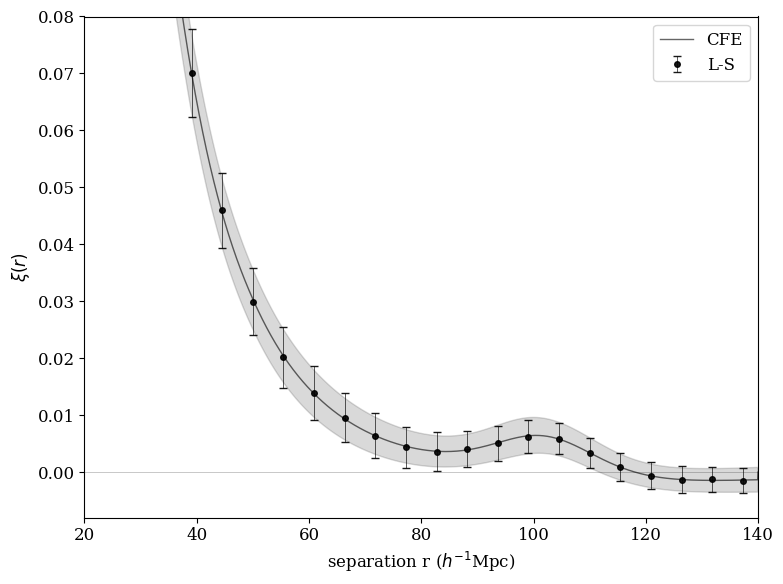

In [26]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(mockset.rcont, cfe_avg, color='k', alpha=0.6, lw=1, label='CFE')
ax.fill_between(mockset.rcont, err_bnds[0], err_bnds[1], color='k', alpha=0.15)

ax.errorbar(mockset.r_avg, ls_avg, ls_std, marker='.', ms=8, capsize=3,
            color='k', ls='None', lw=0.5, alpha=0.9, label='L-S')

format_xi_axes(ax)
ax.legend()
fig.tight_layout()

## compare overall amplitudes: LS + CFE: ln As1x, ln As2x, $\omega=0.001$ As2x

#### As1x

In [27]:
mockset_As1x = MockSet(L, n, rlzs=rlzs, As=1)
# input basis
r_t, cf_t_As1x = np.loadtxt(f"/scratch/ksf293/mocks/lognormal/inputs/cat_{mockset_As1x.cat_tag}_Rh_xi.txt", unpack=True)
# adjust to match scale of interest
cutoff = 150 # Mpc/h
r_t = r_t[np.where(r_t<cutoff)]
cf_t_As1x = cf_t_As1x[np.where(r_t<cutoff)]

In [28]:
# Landy-Szalay
mockset_As1x.load_xi_lss()
ls_avg_As1x = np.mean(mockset_As1x.xi_lss, axis=0)
ls_std_As1x = np.std(mockset_As1x.xi_lss, axis=0)

#### As2x

In [29]:
mockset_As2x = MockSet(L, n, rlzs=rlzs, As=2)
# input basis
r_t, cf_t_As2x = np.loadtxt(f"/scratch/ksf293/mocks/lognormal/inputs/cat_{mockset_As2x.cat_tag}_Rh_xi.txt", unpack=True)
# adjust to match scale of interest
cutoff = 150 # Mpc/h
r_t = r_t[np.where(r_t<cutoff)]
cf_t_As2x = cf_t_As2x[np.where(r_t<cutoff)]

In [30]:
# Landy-Szalay
mockset_As2x.load_xi_lss()
ls_avg_As2x = np.mean(mockset_As2x.xi_lss, axis=0)
ls_std_As2x = np.std(mockset_As2x.xi_lss, axis=0)

In [31]:
# gradient m=075 As2x
mockset_m075 = MockSet(L, n, rlzs=rlzs, As=2)
mockset_m075.add_gradient(grad_dim=3, m=0.75, b=0.5, same_dir=False)
mockset_m075.load_xi_lss()
ls_avg_grad = np.mean(mockset_m075.xi_lss, axis=0)
ls_std_grad = np.std(mockset_m075.xi_lss, axis=0)

In [32]:
bias = 2.0

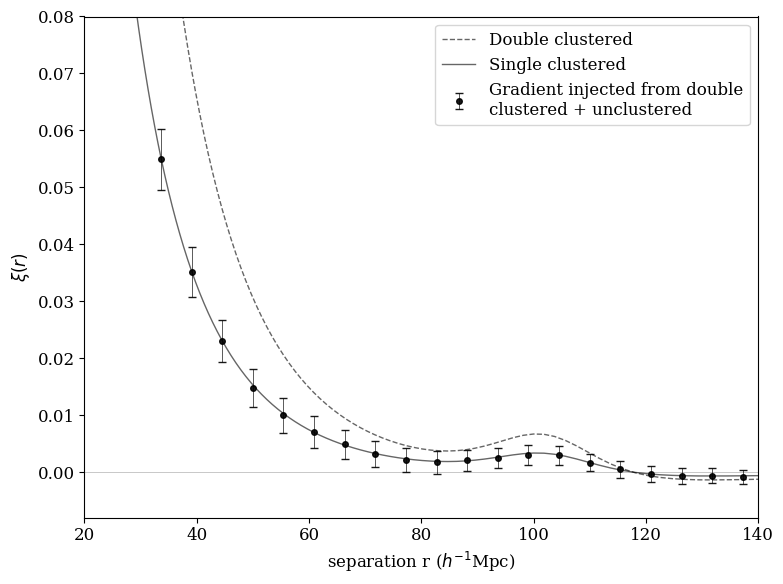

In [33]:
fig, ax = plt.subplots(figsize=(8,6))

# gradient-injected (lognormal As2x + random)
ax.errorbar(mockset_m075.r_avg, ls_avg_grad, ls_std_grad, marker='.', ms=8, capsize=3,
            color='k', ls='None', lw=0.5, alpha=0.9, label=r'Gradient injected from double'+'\n'+'clustered + unclustered')
# input CFs
ax.plot(r_t, cf_t_As2x*bias**2, color='k', ls='--', lw=1, alpha=0.6, label=r'Double clustered')
ax.plot(r_t, cf_t_As1x*bias**2, color='k', ls='-', lw=1, alpha=0.6, label=r'Single clustered')

format_xi_axes(ax)
ax.legend()
fig.tight_layout()

## gradient set: 3D, m=0.5, b=0.5 (random directions)

In [34]:
# mock set
L = 750
n = '2e-4'
rlzs = 1000
mockset = MockSet(L, n, rlzs=rlzs)

In [116]:
# add gradient
grad_dim = 3
m = 0.5
b = 0.5
mockset.add_gradient(grad_dim, m, b, same_dir=False)

### CFE gradient results

#### histogram of gradient amplitudes

In [36]:
amps = load_suave_amps(mockset, basis='bao_iterative')

In [37]:
amps.shape

(1000, 4)

In [38]:
grads_rec = amps.T[1:]/amps.T[0]
grads_rec.shape

(3, 1000)

In [39]:
# expected gradients = omegain / eta_0
grads_exp = np.array([grad_input(mockset, rlz) for rlz in mockset.rlzs])

In [40]:
# analogous histogram of residuals (i.e. subtracting off expected gradient from each grad_rec) ...

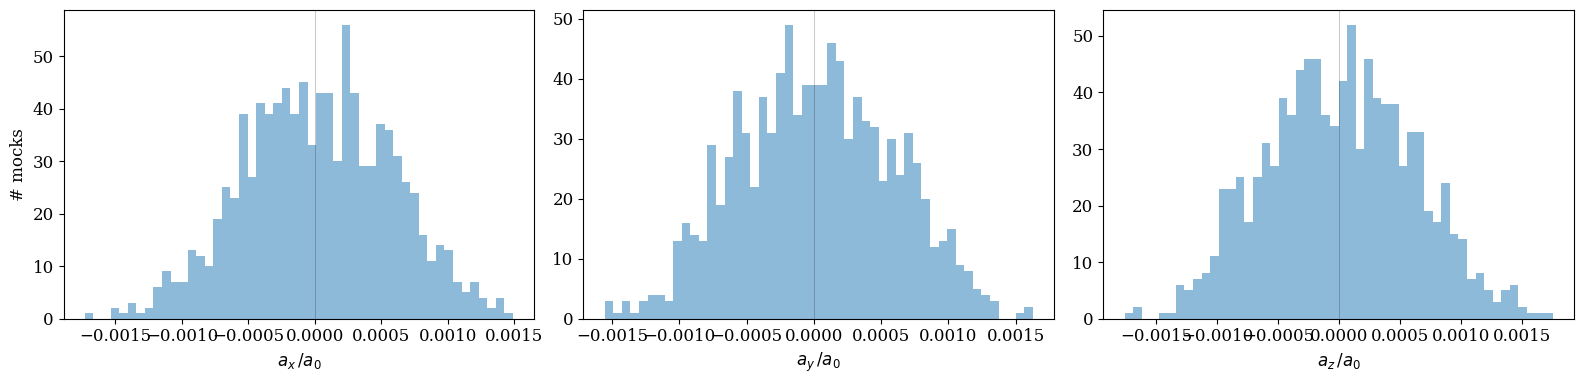

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))

nbins = 50

for i, grad_rec in enumerate(grads_rec):
    ax = axs[i]
    _, _, _ = ax.hist(grad_rec, bins=nbins, alpha=0.5)
    ax.axvline(0, lw=0.5, color='k', alpha=0.3)
    if i==0:
        ax.set_xlabel(r'$a_x\,/a_0$')
        ax.set_ylabel('# mocks')
    if i==1:
        ax.set_xlabel(r'$a_y\,/a_0$')
    if i==2:
        ax.set_xlabel(r'$a_z\,/a_0$')

fig.tight_layout()

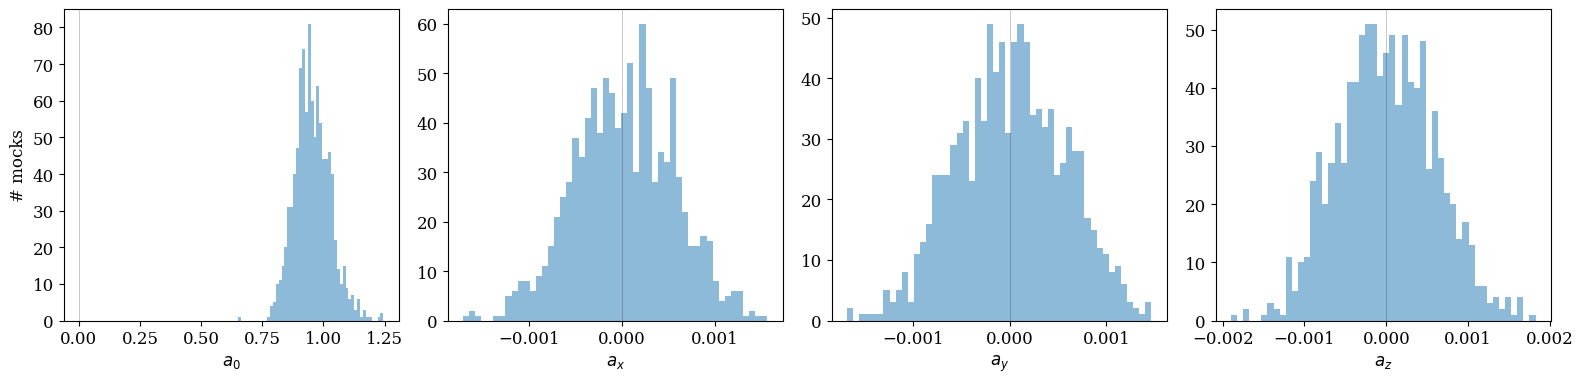

In [42]:
# and raw amplitudes
fig, axs = plt.subplots(1, 4, figsize=(16,4))

nbins = 50

for i, amp in enumerate(amps.T):
    ax = axs[i]
    _, _, _ = ax.hist(amp, bins=nbins, alpha=0.5)
    ax.axvline(0, lw=0.5, color='k', alpha=0.3)
    if i==0:
        ax.set_xlabel(r'$a_0$')
        ax.set_ylabel('# mocks')
    if i==1:
        ax.set_xlabel(r'$a_x$')
    if i==2:
        ax.set_xlabel(r'$a_y$')
    if i==3:
        ax.set_xlabel(r'$a_z$')

fig.tight_layout()

#### single mock result

In [117]:
# params applicable to CFE and patches
rlz = 0
omegain = grad_input(mockset, rlz=rlz)  # true input gradient for this mock
cmap = matplotlib.colormaps['cool']
cbar_label = r'position along gradient $v \,\, (\mathbf{x} = \mathbf{x}_0 + v\mathbf{\hat{\omega}}$) ($h^{-1}$Mpc)'

# do we want to color by the true input gradient?
O = [0,0,0]
vmax = compute_v(omegain, L, O)
# color map
vs_norm = matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax)

t = 5007.2 for the yz-plane
t = 820.3 for the xz-plane
t = 423.1 for the xy-plane
line will intersect first with the xy plane


In [118]:
# xi_locs computed for grad_dim=3, m=0.5, b=0.5, bao_iterative
xi_results = np.load(os.path.join(data_dir, f'plot_data/xi_locs_L750_n2e-4_z057_patchy_As2x_rlz0_m-0.500-L_b-0.500_50vs.npy'), allow_pickle=True).item()
vs = xi_results['vs']
r_fine = xi_results['r_fine']
xi_locs = xi_results['xi_locs']

In [119]:
# to overplot the non-gradient cfe results
xi_cfe = np.load(os.path.join(data_dir, f'{mockset.grad_dir}/suave/xi/bao_iterative/xi_{mockset.cat_tag}_rlz{rlz}_m-{m:.3f}-L_b-{b:.3f}.npy'), allow_pickle=True)[:,1]

In [120]:
# if we wanted to color by the recovered gradient...

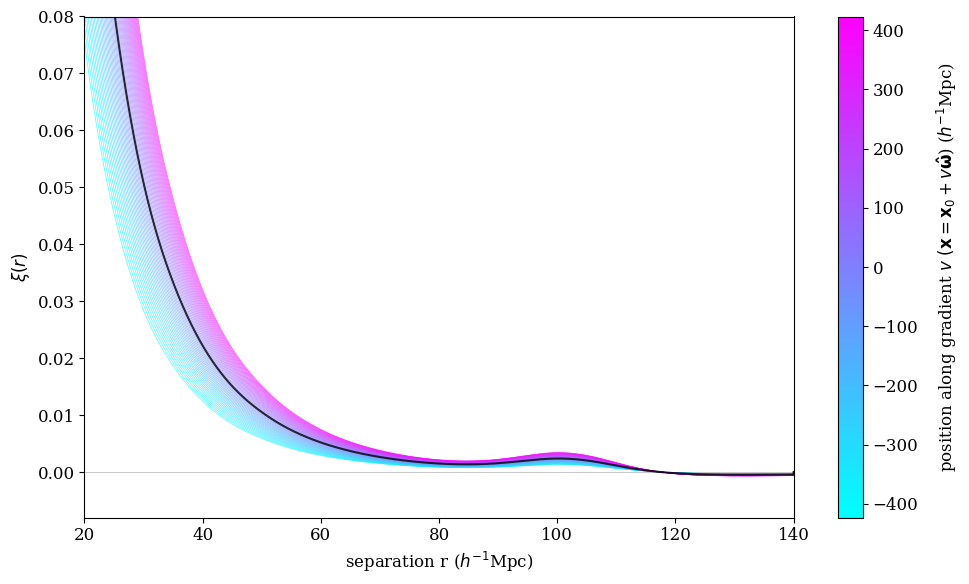

In [121]:
fig, ax = plt.subplots(figsize=(10,6))

for i, v in enumerate(vs):
    p = ax.plot(r_fine, xi_locs[i], color=cmap(vs_norm(v)), lw=0.5, alpha=0.7)
ax.plot(r_fine, xi_cfe, color='k', alpha=0.8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(cbar_label, rotation=90, labelpad=12)
format_xi_axes(ax)
fig.tight_layout()

### patches result

In [101]:
rlz = 0

In [102]:
# mock set
L = 750
n = '2e-4'
rlzs = 1000
mockset = MockSet(L, n, rlzs=rlzs)

In [103]:
# add gradient
grad_dim = 3
m = 0.75
b = 0.5
mockset.add_gradient(grad_dim, m, b, same_dir=False)

In [104]:
patches8_dict = np.load(os.path.join(data_dir, f'{mockset.mock_path}/patches/8patches/grad_amps/{mockset.mock_fn_list[rlz]}.npy'), allow_pickle=True).item()
r_avg = patches8_dict['r_avg']
xi_patches8 = patches8_dict['xi_patches'] # L-S evaluated in each patch
patch_centers8 = patches8_dict['patch_centers']

In [105]:
patches27_dict = np.load(os.path.join(data_dir, f'{mockset.mock_path}/patches/27patches/grad_amps/{mockset.mock_fn_list[rlz]}.npy'), allow_pickle=True).item()
xi_patches27 = patches27_dict['xi_patches'] # L-S evaluated in each patch
patch_centers27 = patches27_dict['patch_centers']

In [106]:
# Landy-Szalay results
r_avg, xi_ls = np.load(os.path.join(data_dir, f'{mockset.mock_path}/ls/xi_ls_3x_{mockset.mock_fn_list[rlz]}.npy'), allow_pickle=True)

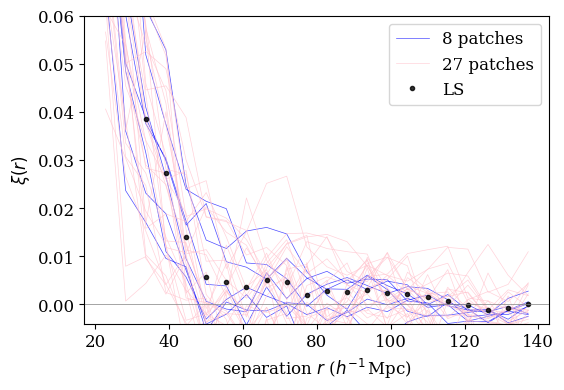

In [107]:
fig, ax = plt.subplots(figsize=(6,4))

for i, xi_patch in enumerate(xi_patches8):
    p = ax.plot(r_avg, xi_patch, lw=0.5, alpha=0.7, color='blue', label='8 patches' if i==0 else None)
for i, xi_patch in enumerate(xi_patches27):
    p = ax.plot(r_avg, xi_patch, lw=0.5, alpha=0.7, color='pink', label='27 patches' if i==0 else None)
# ax.plot(r_fine, xi_cfe, color='k', alpha=0.8)
ax.plot(r_avg, xi_ls, marker='.', color='k', ls='None', alpha=0.8, label='LS')

ax.axhline(0, color='grey', lw=0.5)
ax.set_ylim((-0.004, 0.06))
ax.set_xlabel(r"separation $r$ ($h^{-1}\,$Mpc)")
ax.set_ylabel(r"$\xi(r)$")
ax.legend()

#### color by projection onto gradient direction

In [108]:
# 8 patches
w_patch8 = (patches8_dict['theta'][1:]/patches8_dict['theta'][0]).flatten()  # analogous to w_cont; "theta"

In [109]:
# get the projection of each patch center onto the gradient direction (omegain or w_patch8?)
vs = []
for i, patch_center in enumerate(patch_centers8):
    P = patch_center - L/2 # -L/2 to center at 0
    omegahat = unit(omegain)
    td = t_intersect(omegahat, omegahat, P, O)
    vs.append(td)

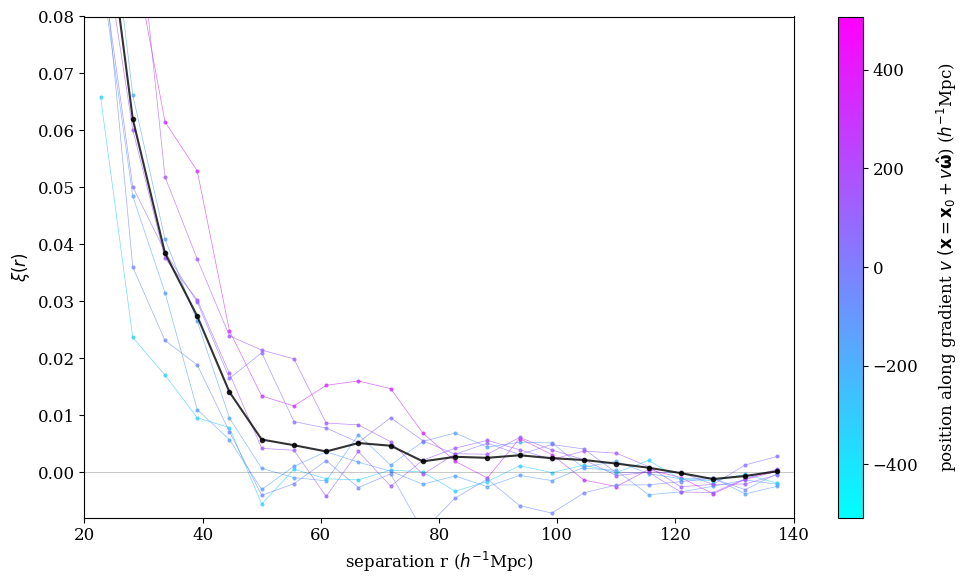

In [110]:
fig, ax = plt.subplots(figsize=(10,6))

for i, v in enumerate(vs):
    loc = patch_centers8[i]
    # label = f'P = [ {loc[0]:.1f}, {loc[1]:.1f}, {loc[2]:.1f} ]'
    p = ax.plot(r_avg, xi_patches8[i], marker='.', ms=4, color=cmap(vs_norm_patch(v)), lw=0.5, alpha=0.7, label=None)
ax.plot(r_avg, xi_ls, color='k', marker='.', alpha=0.8, label=None) #'Landy-Szalay on full mock') # LS results

sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm_patch)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(cbar_label, rotation=90, labelpad=12)

format_xi_axes(ax)
# ax.set_title(r"8 patches: $\vec{\omega}=$"+f"{w_patch8}")
# ax.legend(prop={'size':8})
fig.tight_layout()

In [111]:
# 27 patches
w_patch27 = (patches27_dict['theta'][1:]/patches27_dict['theta'][0]).flatten()  # analogous to w_cont; "theta"
vmax = compute_v(omegain, L, O)

t = -797.4 for the yz-plane
t = 507.8 for the xz-plane
t = 775.9 for the xy-plane
line will intersect first with the xz plane


In [112]:
# color map
vs_norm_patch = matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax)

In [113]:
vs = []
for i, patch_center in enumerate(patch_centers27):
    P = patch_center - L/2 # -L/2 to center at 0
    omegahat = unit(omegain)
    td = t_intersect(omegahat, omegahat, P, O)
    vs.append(td)

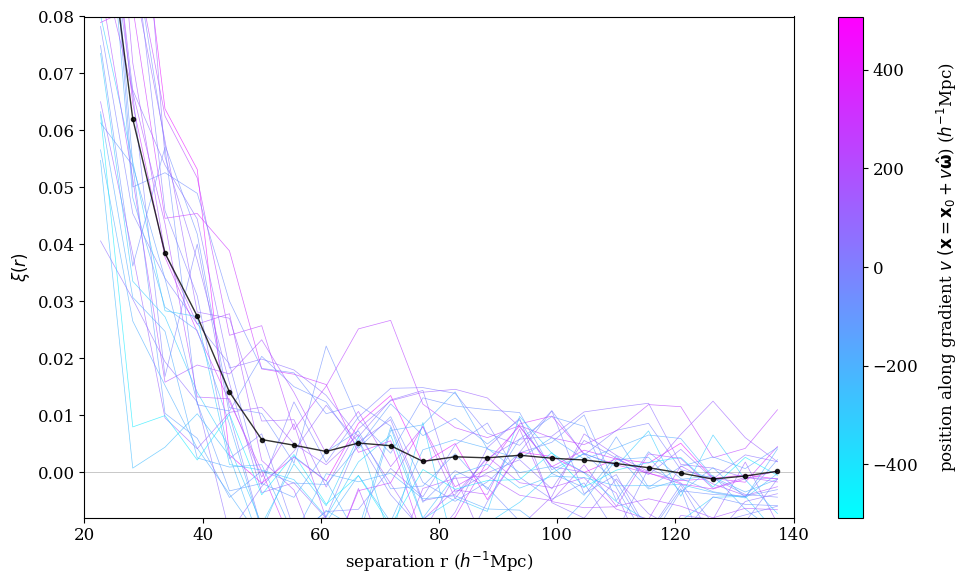

In [115]:
fig, ax = plt.subplots(figsize=(10,6))

for i, v in enumerate(vs):
    loc = patch_centers27[i]
    # label = f'P = [ {loc[0]:.1f}, {loc[1]:.1f}, {loc[2]:.1f} ]'
    p = ax.plot(r_avg, xi_patches27[i], marker=None, ms=4, color=cmap(vs_norm_patch(v)), lw=0.5, alpha=0.7, label=None)
ax.plot(r_avg, xi_ls, color='k', marker='.', alpha=0.8, lw=1, label=None) # LS results

sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm_patch)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(cbar_label, rotation=90, labelpad=12)

format_xi_axes(ax)
# ax.set_title(r"27 patches: $\vec{\omega}=$"+f"{w_patch27}")
# ax.legend(prop={'size':6})
fig.tight_layout()

### Precision scalings

In [34]:
# from the expected_precision notebook, we've decided to use PkG at r=40 as our representative value:
k_rep, P_rep = get_PkG(40)

#### Boxsize

In [35]:
tags = np.array([[500, 0.5],
        [750, 0.75],
        [1000, 1.0]])
        #[1500, 1]])
n = '2e-4'
grad_dim = 2
b = 0.5
nmocks = 1000

In [36]:
amp_arr = np.empty((len(tags), nmocks, 4))
for i, (L, m) in enumerate(tags):
    mockset = MockSet(int(L), n, rlzs=nmocks)
    mockset.add_gradient(grad_dim, m, b)
    amp_arr[i] = load_suave_amps(mockset, basis='bao_iterative')

In [37]:
# compress the amplitudes along the realizations to get the spread for each amplitude for each boxsize
amp_stds_L = np.std(amp_arr, axis=1)  # (4,4) array

In [38]:
Ls = tags[:,0]
Ls_cont = np.linspace(min(Ls), max(Ls), 100)
expected_scalings = std_grad(Ls_cont**3, float(n), P_rep)

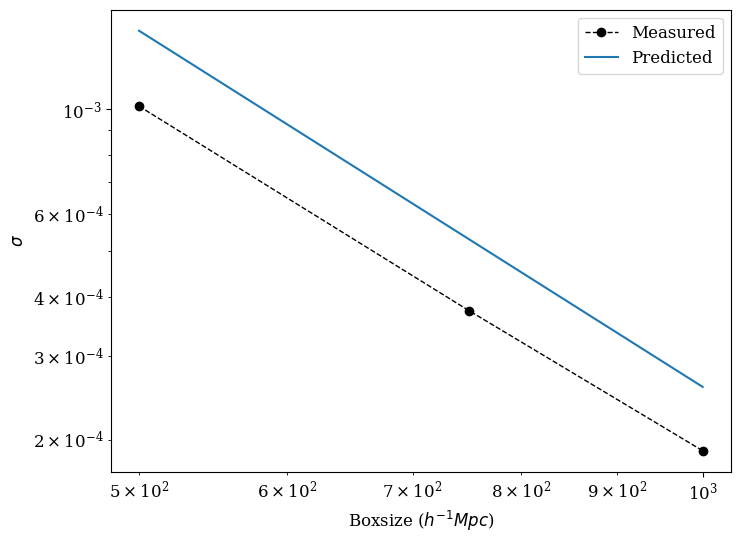

In [39]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(Ls, amp_stds_L[:,1], marker='o', ls='--', lw=1, color='k', label='Measured')
ax.plot(Ls_cont, expected_scalings*10**-1, label='Predicted')

ax.set_xlabel('Boxsize ($h^{-1}Mpc$)')
ax.set_ylabel('$\sigma$')
# ax.set_title('Precision scalings with boxsize')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

## 2D recovered gradients

### CFE

#### L500

In [40]:
L = 500
n = '2e-4'
grad_dim = 2
nmocks = 500

In [41]:
# m = 0.25
m = 0.25
mockset = MockSet(L, n, rlzs=nmocks)
mockset.add_gradient(grad_dim, m, b=0.5)
amps_dict_L500_m025 = check_grad_amps(mockset, method='suave', plot=False, return_amps=True)

In [42]:
# m = 0.375
m = 0.375
mockset = MockSet(L, n, rlzs=nmocks)
mockset.add_gradient(grad_dim, m, b=0.5)
amps_dict_L500_m0375 = check_grad_amps(mockset, method='suave', plot=False, return_amps=True)

In [43]:
# m = 0.5
m = 0.5
mockset = MockSet(L, n, rlzs=nmocks)
mockset.add_gradient(grad_dim, m, b=0.5)
amps_dict_L500_m05 = check_grad_amps(mockset, method='suave', plot=False, return_amps=True)

#### L750

In [44]:
L = 750
n = '2e-4'
grad_dim = 2
nmocks = 500

In [45]:
# m = 0.375
m = 0.375
mockset = MockSet(L, n, rlzs=nmocks)
mockset.add_gradient(grad_dim, m, b=0.5)
amps_dict_L750_m0375 = check_grad_amps(mockset, method='suave', plot=False, return_amps=True)

In [46]:
# m = 0.563
m = 0.563
mockset = MockSet(L, n, rlzs=nmocks)
mockset.add_gradient(grad_dim, m, b=0.5)
amps_dict_L750_m0563 = check_grad_amps(mockset, method='suave', plot=False, return_amps=True)

In [47]:
# m = 0.75
m = 0.75
mockset = MockSet(L, n, rlzs=nmocks)
mockset.add_gradient(grad_dim, m, b=0.5)
amps_dict_L750_m075 = check_grad_amps(mockset, method='suave', plot=False, return_amps=True)

#### L1000

In [48]:
L = 1000
n = '2e-4'
grad_dim = 2
nmocks = 500

In [49]:
# m = 0.5
m = 0.5
mockset = MockSet(L, n, rlzs=nmocks)
mockset.add_gradient(grad_dim, m, b=0.5)
amps_dict_L1000_m05 = check_grad_amps(mockset, method='suave', plot=False, return_amps=True)

In [50]:
# m = 0.75
m = 0.75
mockset = MockSet(L, n, rlzs=nmocks)
mockset.add_gradient(grad_dim, m, b=0.5)
amps_dict_L1000_m075 = check_grad_amps(mockset, method='suave', plot=False, return_amps=True)

In [51]:
# m = 1
m = 1.
mockset = MockSet(L, n, rlzs=nmocks)
mockset.add_gradient(grad_dim, m, b=0.5)
amps_dict_L1000_m1 = check_grad_amps(mockset, method='suave', plot=False, return_amps=True)

### plot

In [52]:
# boxsizes and m values
Ls = [500, 750, 1000]
ms = np.array([[0.25, 0.375, 0.5],
      [0.375, 0.563, 0.75],
    [0.5, 0.75, 1.0]])

In [53]:
# input gradients
input_grads = np.array([[amps_dict_L500_m025['grads_exp'][0],
                         amps_dict_L500_m0375['grads_exp'][0],
                         amps_dict_L500_m05['grads_exp'][0]],
                        [amps_dict_L750_m0375['grads_exp'][0],
                         amps_dict_L750_m0563['grads_exp'][0],
                         amps_dict_L750_m075['grads_exp'][0]],
                        [amps_dict_L1000_m05['grads_exp'][0],
                         amps_dict_L1000_m075['grads_exp'][0],
                         amps_dict_L1000_m1['grads_exp'][0]]
                       ])
input_grads.shape

(3, 3, 3)

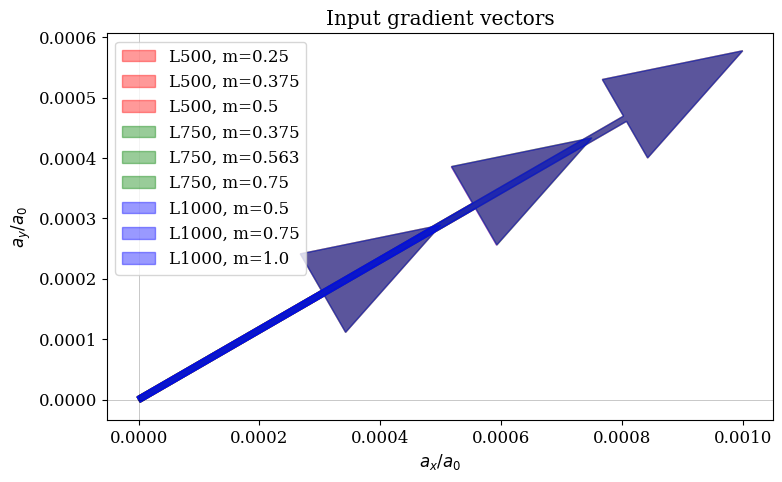

In [54]:
fig, ax = plt.subplots(figsize=(8,6))
cs = ['r', 'g', 'b']
for i, L_set in enumerate(input_grads):
    for j, grad_exp in enumerate(L_set):
        ax.arrow(0,0,grad_exp[0], grad_exp[1], color=cs[i], alpha=0.4, length_includes_head=True,
                 width=0.00001, head_width=0.00015, label=f'L{Ls[i]}, m={ms[i,j]}')

ax.axvline(0, color='k', lw=0.5, alpha=0.3)
ax.axhline(0, color='k', lw=0.5, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlabel(r'$a_x / a_0$')
ax.set_ylabel(r'$a_y / a_0$')
ax.set_title('Input gradient vectors')
ax.legend(loc=2)
fig.tight_layout()

In [55]:
# recovered gradients
nmocks = 500
recovered_grads = np.array([[amps_dict_L500_m025['grads_rec'][:nmocks],
                             amps_dict_L500_m0375['grads_rec'][:nmocks],
                             amps_dict_L500_m05['grads_rec'][:nmocks]],
                            [amps_dict_L750_m0375['grads_rec'][:nmocks],
                             amps_dict_L750_m0563['grads_rec'][:nmocks],
                             amps_dict_L750_m075['grads_rec'][:nmocks]],
                            [amps_dict_L1000_m05['grads_rec'][:nmocks],
                             amps_dict_L1000_m075['grads_rec'][:nmocks],
                             amps_dict_L1000_m1['grads_rec'][:nmocks]],
                           ])
recovered_grads.shape

(3, 3, 500, 3)

In [56]:
# medians and standard deviation of recovered grads
medians_rec = np.empty((recovered_grads.shape[0], recovered_grads.shape[1], recovered_grads.shape[-1]))
stds_rec = np.empty(medians_rec.shape)
for i, boxsize_set in enumerate(recovered_grads):
    for j, grads_rec in enumerate(boxsize_set):
        medians_rec[i,j] = np.median(grads_rec, axis=0)
        stds_rec[i,j] = np.std(grads_rec, axis=0)

In [57]:
# input gradients
omegains = [ms[0,i]/Ls[0] for i in range(len(ms))]

In [58]:
omegains

[0.0005, 0.00075, 0.001]

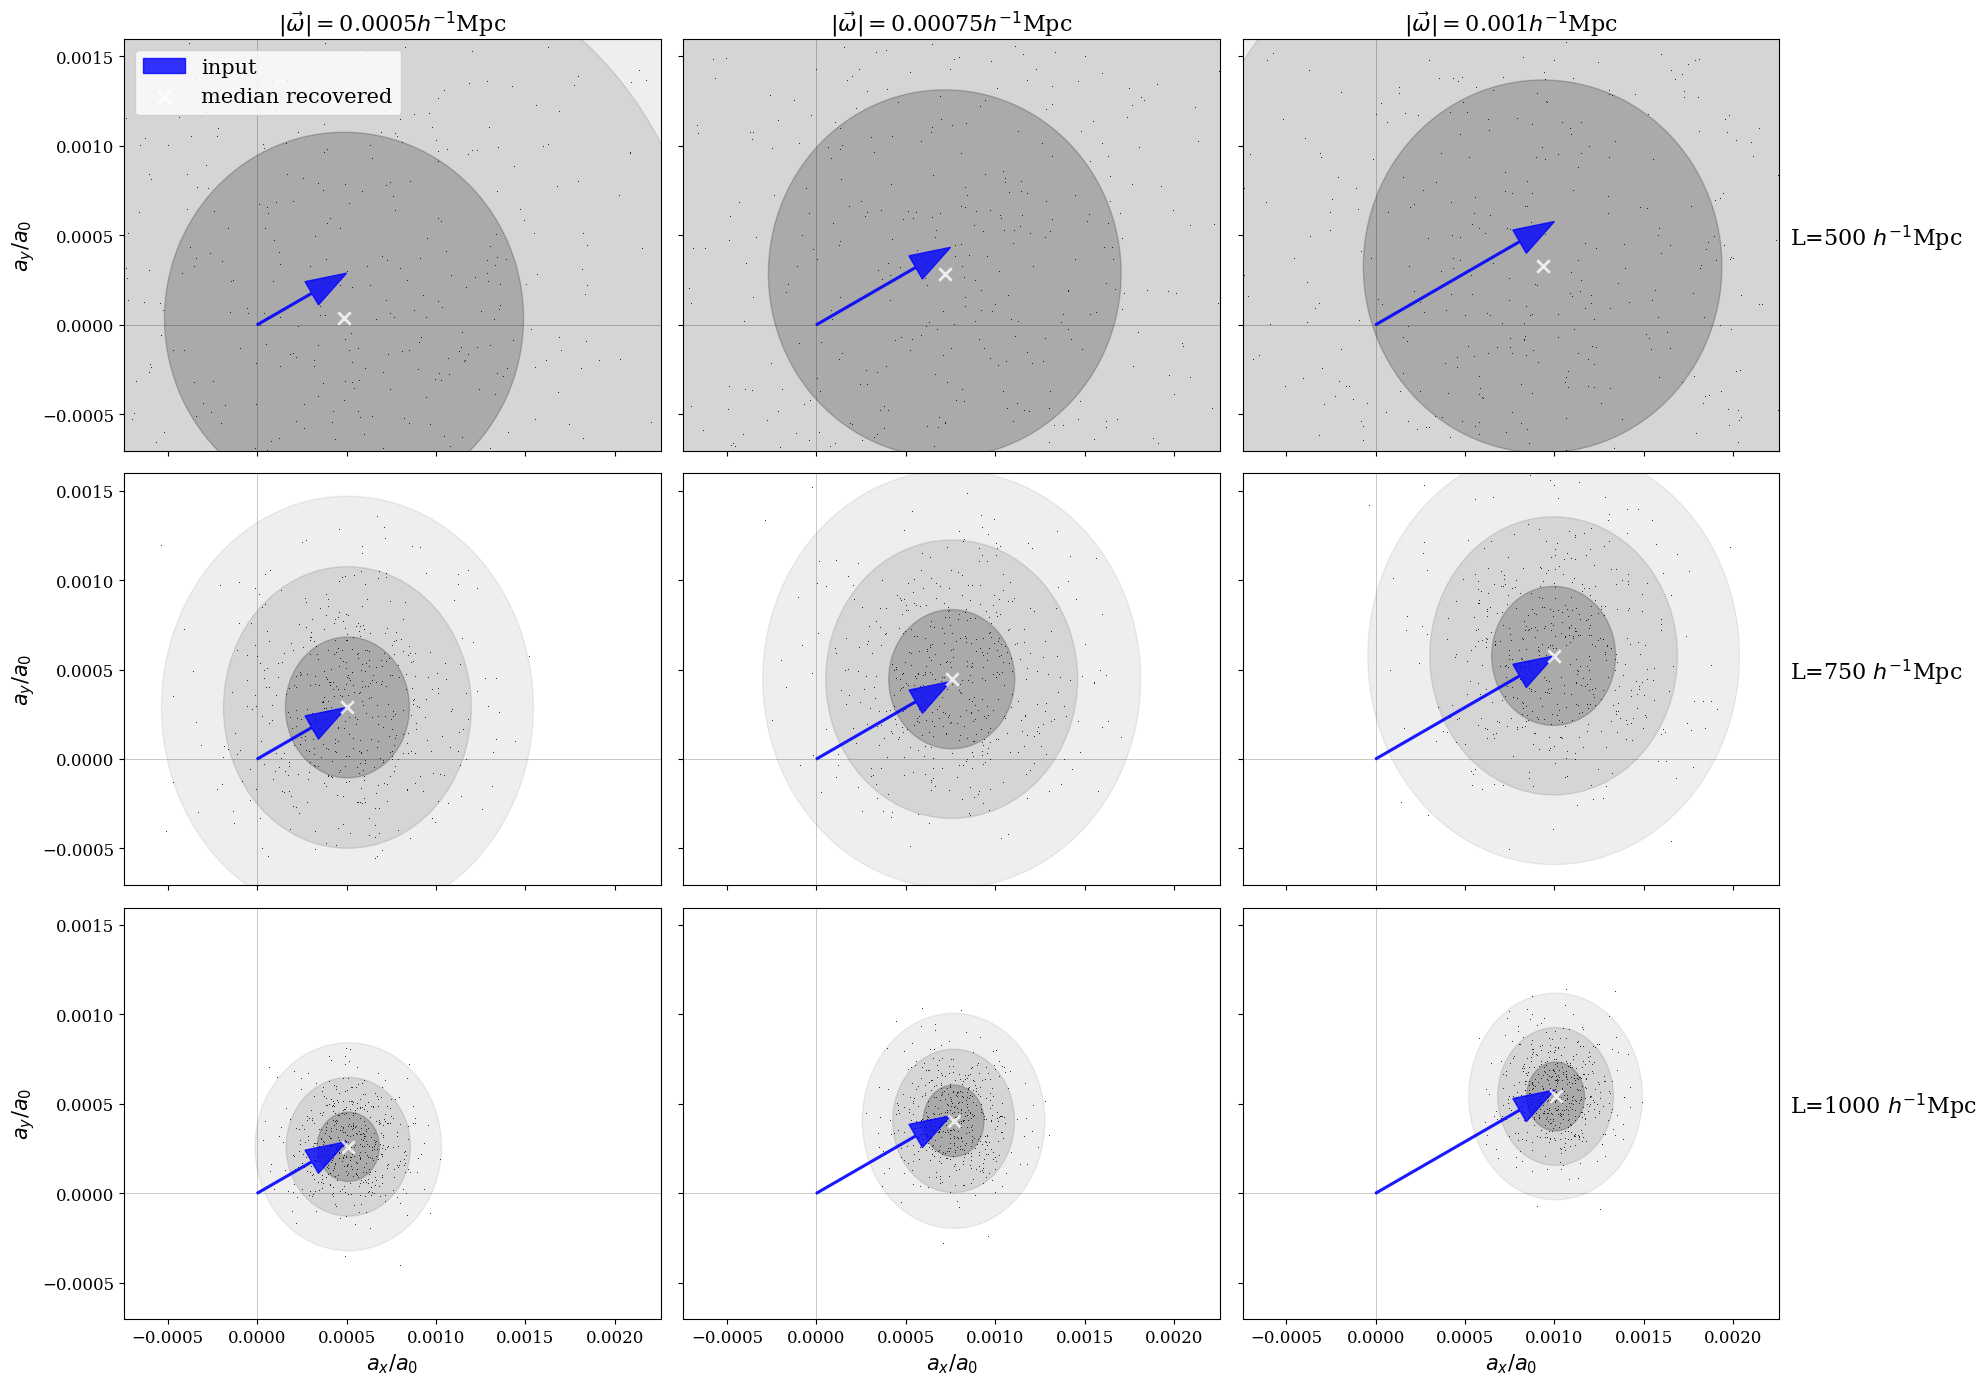

In [59]:
fig, axs = plt.subplots(3, 3, figsize=(20,14))

leg_loc = 2
fs = 15

# median recovered
centerx, centery = [medians_rec[1,1,0], medians_rec[1,1,1]]
xlim = (centerx-.0015, centerx+.0015)
ylim = (centery-.00115, centery+.00115)

for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        
        # plot individual realizations
        ax.plot(recovered_grads[i,j,:,0], recovered_grads[i,j,:,1], marker=',', color='k', alpha=0.8,
                markersize=2, ls='None')
        
        # input gradient arrow
        ax.arrow(0, 0, input_grads[i,j,0], input_grads[i,j,1], color='blue', alpha=0.8,
                 length_includes_head=True, width=0.00001, head_width=0.00015,label='input', zorder=100)
        
        # ellipse: spread of recovered amplitudes, centered at the median recovered gradient
        for k in range(1,4):
            ellipse1 = Ellipse(xy=(medians_rec[i,j,0], medians_rec[i,j,1]), width=k*2*stds_rec[i,j,0],
                               height=k*2*stds_rec[i,j,1], color='k', fill=True, alpha=0.2/k)
            ax.add_patch(ellipse1)
        
        # median recovered
        ax.scatter(medians_rec[i,j,0], medians_rec[i,j,1], color='white', alpha=0.8,
                   lw=2, marker='x', s=80, zorder=101, label='median recovered')
        
        # top two rows
        if i<2:
            ax.xaxis.set_tick_params(labelbottom=False)
        # top row
        if i==0:
            ax.text(0.5, 1.02, r'$\vert\vec{\omega}\vert=$'+str(omegains[j])+r'$h^{-1}$Mpc', transform=ax.transAxes, fontsize=16, ha='center')
            if j==0:
                ax.legend(loc=leg_loc, prop={'size':fs})
        # bottom row
        if i==2:
            ax.set_xlabel(r'$a_x/a_0$', fontsize=fs)
        # right two columns
        if j>0:
            ax.yaxis.set_tick_params(labelleft=False)
        # right-most column
        if j==2:
            ax.text(1.02, 0.5, f'L={Ls[i]} '+r'$h^{-1}$Mpc', transform=ax.transAxes, fontsize=16)
        # left-most column
        if j==0:
            ax.set_ylabel(r'$a_y/a_0$', fontsize=fs)
        
        ax.axvline(0, color='k', lw=0.5, alpha=0.3)
        ax.axhline(0, color='k', lw=0.5, alpha=0.3)
        ax.set_aspect('equal')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

fig.tight_layout()